## Final Capstone - Sentiment Analysis of Yelp Business Reviews </br>

Part II: Pre-process & Model

Biman Mondal

July 30, 2025

### Objective </br>

<span style="color: blue; font-family: Arial; font-size: 16px; background-color: #EEEEEE">
The objective of the final capstone is to create several machine learning models which predict the sentiment of the customer reviews. Using some prebuilt sentiment analyzers like VADER and BERT, we will compare results ML classification models to pre-built models. The capstone's objective is to understand the nuance of performing natural language processing (NLP) and the various approaches to performing NLP tasks.</br>
</br>
This notebook finalizes the dataset and creates a model for comparison.
</span>

### Import Libraries

In [8]:
# Import numpy package
import numpy as np

# Import pandas package
import pandas as pd

# Import matplotlib package
import matplotlib.pyplot as plt
# Import the seaborn package
import seaborn as sns

# Import time
import time
# Import tqdm to monitor for loop progress
from tqdm import tqdm 
# Import operating system library
import os
import string
# Serialize Data
import pickle 

# Parallel processing
from multiprocessing import Pool, cpu_count

###############################################
# NLP IMPORTS
###############################################
# Import NLTK and all submodules
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Import contractions
import contractions
# Import Spacy
import spacy
#
# Import Counter
from collections import Counter

#Term frequency vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
# Transformers pipeline
from transformers import pipeline

###############################################
# ML IMPORTS
###############################################

# Train Test Split
from sklearn.model_selection import train_test_split

# ML Models
from sklearn.linear_model import LogisticRegression
# Naive Bayes
from sklearn.naive_bayes import MultinomialNB
# Support Vector Machines
from sklearn.svm import LinearSVC
# Random Forest
from sklearn.ensemble import RandomForestClassifier

# Get accuracy score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report

In [204]:
#!pip install -q transformers
#!pip uninstall numpy
#!pip install --user numpy==1.8
#print(np.__version__)
#nltk.download('vader_lexicon') # one time only

### Read dataframe
<strong> About the dataframe:</strong></br>
The Yelp reviews dataset consists of reviews from Yelp. It is extracted from the Yelp Dataset Challenge 2015 data.\
http://www.yelp.com/dataset_challenge </br>
The dataset is sourced from hugging face.</br>
https://huggingface.co/datasets/Yelp/yelp_review_full</br>
The dataset consists of two .csv files: training.csv with 650k records and test.csv. with 50k records.</br>

<strong> Assume:</strong> </br>
<span style="color: blue; font-family: Arial; font-size: 16px; background-color: #EEEEEE">
As seen in the previous data wrangling / exploratory data analysis notebook, the star ratings are equally distributed in the dataframe. In order to model the dataset (1,2) stars are categorized as "negative" / -1, while (3) stars is "neutral" / 0 and (4,5) stars are categorized as "positive" / 1. 
</span>

In [2]:
# Read Dataframe
df = pd.read_csv('../data/raw/yelp_review_fine-grained_5_classes_csv/train.csv', header='infer')
df.head()

,class_index,review_text
0,5,dr. goldberg offers everything i look for in a...
1,2,"Unfortunately, the frustration of being Dr. Go..."
2,4,Been going to Dr. Goldberg for over 10 years. ...
3,4,Got a letter in the mail last week that said D...
4,1,I don't know what Dr. Goldberg was like before...


## Text Normalization</br>

<span style="color: blue; font-family: Arial; font-size: 16px; background-color: #EEEEEE">
Continue from previous notebook to process the review text.</br>
Normalization is the process that brings words into standard format.
    Stemming reduces words to their root form by chopping off suffixes (running -> run) however may lead to non-valid words (organization -> organizat).</br>
    Lemmatization is the process of reducing inflected forms of a word to its lemma, or base form, as found in a dictionary.
</span>
</br>
<span style="color: red; font-family: Arial; font-size: 16px; background-color: #EEEEEE">
Processing the entire dataframe of 650k records took over 20 hours using the following script.
For expediency, the pickled file format of the processed dataframe were saved locally and read subsequently. 
</span>

In [5]:
def process_text(text_list, nlp):
    start = time.time()
    # Create a count of tokenized text
    # Remove contractions and stop words
    processed_text = list()
    for text in tqdm(text_list):
        # Tokenize the lowered text and fix contractions
        tokens = word_tokenize(contractions.fix(text.lower()))
        # Remove stop words and punctuations in the tokens list
        filtered_tokens = [token for token in tokens if token not in stopwords.words('english')]
        filtered_tokens = [token for token in filtered_tokens if token not in (string.punctuation or "''")]
        # Remove all non alpha numeric values like elipses '...' and empty strings
        #filtered_tokens = [val for val in filtered_tokens if val.isalpha()]
        filtered_text = ' '.join(filtered_tokens)
        # Lemmatize tokens
        lemmatized_tokens = [token.lemma_ for token in nlp(filtered_text)]
        # Lemmatized text
        lemmatized_text = ' '.join(lemmatized_tokens)
        # Add to token list to be counted
        processed_text.append(lemmatized_text)   
        
    end = time.time()
    print(f"Time elapsed: {round((end - start)/60,1)} min")
    return processed_text

# Model
nlp = spacy.load("en_core_web_sm", disable=["tagger", "parser", "ner"])

"""
# Pre-process text of dataframe
#sample_df = df.sample(frac=0.1)
#sample_df = df.sample(n=5000, random_state=9)
#processed_text = process_text(sample_df['review_text'].values.tolist(), nlp)

# Pre-process entire dataframe
df["processed_text"] = process_text(df['review_text'].values.tolist(), nlp)

# Save processed dataframe
file_name = 'dataframe_processed_complete.pkl'
with open(file_name, 'wb') as f:  # open a text file
    pickle.dump(df, f) # serialize the list
f.close()
"""

'\n# Pre-process text of dataframe\n#sample_df = df.sample(frac=0.1)\n#sample_df = df.sample(n=5000, random_state=9)\n#processed_text = process_text(sample_df[\'review_text\'].values.tolist(), nlp)\n\n# Pre-process entire dataframe\ndf["processed_text"] = process_text(df[\'review_text\'].values.tolist(), nlp)\n\n# Save processed dataframe\nfile_name = \'dataframe_processed_complete.pkl\'\nwith open(file_name, \'wb\') as f:  # open a text file\n    pickle.dump(df, f) # serialize the list\nf.close()\n'

</br>
<span style="color: red; font-family: Arial; font-size: 16px; background-color: #EEEEEE">
Processing the entire dataframe of 650k records took over 20 hours using the following script.</br>
For expediency, the pickled file format of the processed dataframe were saved locally and read subsequently. 
</span>

### Save / Read Pickled Data

In [3]:
# Save data
'''
# Save data
file_name = 'processed_text.pkl'

with open(file_name, 'wb') as f:  # open a text file
    pickle.dump(processed_text, f) # serialize the list
f.close()
'''
# Read Data
with open('dataframe_processed_NLTKsentiment.pkl', 'rb') as f:
    df_processed = pickle.load(f) # deserialize using load()
    #print(loaded_processed_text) # print student names

# Convert Star value to numerical sentiment
# [1,2] stars == 'negative' == -1
# 3 stars == "neutral" == 0
# 4 stars == "positive" == 1

def mapfunc(x):
    output = None
    if x==1 or x==2:
        output = -1
    elif x==3:
        output = 0
    elif x==4 or x==5:
        output = 1
    return output
# Apply map function to dataframe column
df_processed['star_sentiment'] = df_processed['class_index']\
                                .map(lambda x: mapfunc(x))
df_processed.head()

,class_index,review_text,processed_text,sentiment,star_sentiment,sent_num
0,5,dr. goldberg offers everything i look for in a...,goldberg offers everything look general practi...,positive,1,1
1,2,"Unfortunately, the frustration of being Dr. Go...",unfortunately frustration goldberg patient rep...,negative,-1,-1
2,4,Been going to Dr. Goldberg for over 10 years. ...,going goldberg years think one patients starte...,positive,1,1
3,4,Got a letter in the mail last week that said D...,got letter mail last week said goldberg moving...,neutral,1,0
4,1,I don't know what Dr. Goldberg was like before...,know goldberg like moving arizona let tell sta...,neutral,-1,0


In [39]:
df_processed.loc[df_processed['star_sentiment']==1].count()
# Down sample to avoid 


class_index       260000
review_text       260000
processed_text    260000
sentiment         260000
star_sentiment    260000
sent_num          260000
dtype: int64

## Perform Multi-label Classification

### Create TFDIF Features and Split Dataset

In [4]:
start = time.time()
# TFIDF vectorizer
vectorizer = TfidfVectorizer(max_features=10000)

# Fit transform
tfidf_matrix = vectorizer.fit_transform(df_processed.processed_text)
print("TFIDF sparse matrix size:\n", tfidf_matrix.shape)

# Convert sparse matrix to an array
#tfidf_dense = tfidf_matrix.toarray()
#print(tfidf_dense.shape)
# Get out word list from fit
#tfidf_feature_names = vectorizer.get_feature_names_out()

# Convert processed data to Pandas dataframe
# The matrix of TF-IDF creates a matrix columns associated with the words and
# rows designate their score
#df_tfidf = pd.DataFrame(
#                tfidf_dense,
#                columns = tfidf_feature_names
#                )

# Set X as the TF-IDF transformed matrix
X = tfidf_matrix
# Set Y as the number of stars
y = df_processed.star_sentiment
# Split data 70% train / 30% test
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size= 0.3, random_state= 9)
end = time.time()
print(f"Time elapsed: {round((end - start)/60,1)} min")

TFIDF sparse matrix size:
 (650000, 10000)
Time elapsed: 0.8 min


<span style="color: blue; font-family: Arial; font-size: 16px; background-color: #EEEEEE">
Converting TFIDF sparse matrix to array results in memory error until max-features per document is lowered below 10k. 
</span>

### Log Regression

LogisticRegression(C=0.01,
                   class_weight={-1: 0.8333333333333334, 0: 1.6666666666666667,
                                 1: 0.8333333333333334},
                   max_iter=10000)
              precision    recall  f1-score   support

          -1       0.83      0.77      0.80     77944
           0       0.45      0.60      0.51     39097
           1       0.83      0.75      0.79     77959

    accuracy                           0.73    195000
   macro avg       0.70      0.71      0.70    195000
weighted avg       0.75      0.73      0.74    195000

[[59922 14344  3678]
 [ 7767 23395  7935]
 [ 4900 14559 58500]]


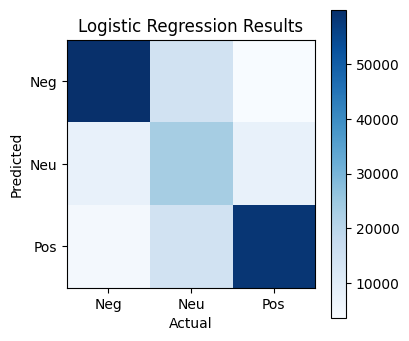

Time elapsed: 0.2 min


In [41]:
start = time.time()
# Set regularization rate
reg = 100
# train a logistic regression model on the training set
log_model = LogisticRegression(C=1/reg, class_weight = {-1:0.833, 0:1.667, 1:0.833},
                                        solver='lbfgs',  
                                        max_iter=10000)\
                                        .fit(X_train, y_train)
print(log_model)

# Determine prediction
log_pred = log_model.predict(X_test)

# Print Classification Report
print(classification_report(y_test, log_pred))

# Confusion matrix
mcm_log = confusion_matrix(y_test, log_pred)
print(mcm_log)

# Plot confusion Matrix
plt.figure(figsize = (4,4))
plt.imshow(mcm_log, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(3)
#plt.xticks(tick_marks, [-1,0,1])
#plt.yticks(tick_marks, [-1,0,1])
plt.xticks(tick_marks, ["Neg","Neu","Pos"])
plt.yticks(tick_marks, ["Neg","Neu","Pos"])
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title('Logistic Regression Results')
plt.show()
#
end = time.time()
print(f"Time elapsed: {round((end - start)/60,1)} min")

## Naive Bayes Model

MultinomialNB()
              precision    recall  f1-score   support

          -1       0.75      0.84      0.79     77944
           0       0.51      0.16      0.25     39097
           1       0.71      0.87      0.78     77959

    accuracy                           0.72    195000
   macro avg       0.66      0.62      0.61    195000
weighted avg       0.69      0.72      0.68    195000

[[65385  4477  8082]
 [13435  6314 19348]
 [ 8550  1583 67826]]


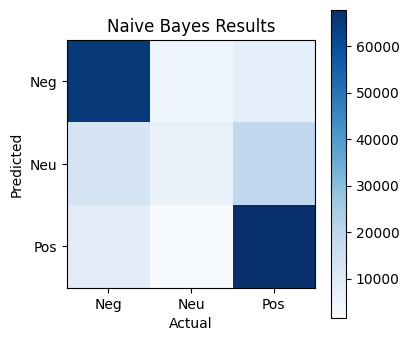

Time elapsed: 0.0 min


In [46]:
start = time.time()

nb_model = MultinomialNB()\
                        .fit(X_train, y_train)
print(nb_model)
nb_y_pred = nb_model.predict(X_test)

# Print Classification Report
print(classification_report(y_test, nb_y_pred))

# Confusion matrix
mcm_nb = confusion_matrix(y_test, nb_y_pred)
print(mcm_nb)

# Plot confusion Matrix
plt.figure(figsize = (4,4))
plt.imshow(mcm_nb, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(3)
#plt.xticks(tick_marks, [-1,0,1])
#plt.yticks(tick_marks, [-1,0,1])
plt.xticks(tick_marks, ["Neg","Neu","Pos"])
plt.yticks(tick_marks, ["Neg","Neu","Pos"])
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title('Naive Bayes Results')
plt.show()
#
end = time.time()
print(f"Time elapsed: {round((end - start)/60,1)} min")

## Support Vector Machine Model

LinearSVC(class_weight={-1: 0.833, 0: 1.667, 1: 0.833})
              precision    recall  f1-score   support

          -1       0.82      0.84      0.83     77944
           0       0.51      0.46      0.48     39097
           1       0.82      0.84      0.83     77959

    accuracy                           0.76    195000
   macro avg       0.72      0.71      0.71    195000
weighted avg       0.76      0.76      0.76    195000

[[65585  8571  3788]
 [10232 17925 10940]
 [ 3854  8566 65539]]


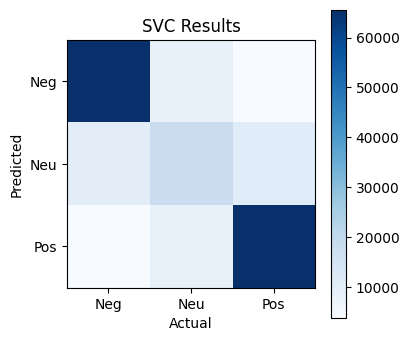

Time elapsed: 0.9 min


In [47]:
start = time.time()

svc_model = LinearSVC(class_weight = {-1:0.833, 0:1.667, 1:0.833})\
                                    .fit(X_train, y_train)
print(svc_model)
svc_y_pred = svc_model.predict(X_test)
# Print Classification Report
print(classification_report(y_test, svc_y_pred))

# Confusion matrix
mcm_svc = confusion_matrix(y_test, svc_y_pred)
print(mcm_svc)

# Plot confusion Matrix
plt.figure(figsize = (4,4))
plt.imshow(mcm_svc, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(3)
#plt.xticks(tick_marks, [-1,0,1])
#plt.yticks(tick_marks, [-1,0,1])
plt.xticks(tick_marks, ["Neg","Neu","Pos"])
plt.yticks(tick_marks, ["Neg","Neu","Pos"])
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title('SVC Results')
plt.show()
#
end = time.time()
print(f"Time elapsed: {round((end - start)/60,1)} min")

### Random Forest Classfier

RandomForestClassifier(class_weight={-1: 0.833, 0: 1.667, 1: 0.833},
                       max_depth=3, random_state=9)
              precision    recall  f1-score   support

          -1       0.72      0.61      0.66     77944
           0       0.38      0.35      0.36     39097
           1       0.63      0.76      0.69     77959

    accuracy                           0.62    195000
   macro avg       0.58      0.57      0.57    195000
weighted avg       0.62      0.62      0.61    195000

[[47434 12085 18425]
 [ 9184 13547 16366]
 [ 8929 10069 58961]]


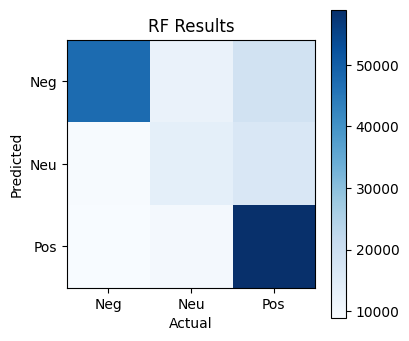

Time elapsed: 0.5 min


In [51]:
start = time.time()
# Random Forest Classifier
rf_model = RandomForestClassifier(class_weight = {-1:0.833, 0:1.667, 1:0.833},
                                  n_estimators=100,max_depth=3,
                                  random_state=9)\
                                 .fit(X_train, y_train)
print(rf_model)

# Prediction
rf_y_pred = rf_model.predict(X_test)
# Print Classification Report
print(classification_report(y_test, rf_y_pred))
# Calculate confusion matrix
mcm_rf = confusion_matrix(y_test, rf_y_pred)
print(mcm_rf)

# Plot confusion Matrix
plt.figure(figsize = (4,4))
plt.imshow(mcm_rf, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(3)
#plt.xticks(tick_marks, [-1,0,1])
#plt.yticks(tick_marks, [-1,0,1])
plt.xticks(tick_marks, ["Neg","Neu","Pos"])
plt.yticks(tick_marks, ["Neg","Neu","Pos"])
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title('RF Results')
plt.show()
#
end = time.time()
print(f"Time elapsed: {round((end - start)/60,1)} min")

### Sentiment Analysis using NLTK VADER</br>

In [60]:
"""
# Load processed dataframe
with open('dataframe_processed_full.pkl', 'rb') as f:
    df_processed = pickle.load(f) # deserialize using load()

#print(loaded_processed_text) # print student names
"""

In [34]:
def get_sentiment(text, analyzer):
    # Get the sentiment polarity from text
    scores = analyzer.polarity_scores(text)
    
    if scores['compound'] > 0.4:
        sentiment = 'positive'
    elif scores['compound'] <-0.4:
        sentiment = 'negative'
    else:
        sentiment = 'neutral'
    #sub_dict = {k: v for k, v in scores.items() if k in ['neg', 'neu', 'pos']}
    #sentiment = max(sub_dict, key=sub_dict.get)
    return scores, sentiment

In [35]:
start = time.time()
# Determine the sentiment of entire training set
analyzer = SentimentIntensityAnalyzer()
sent_results = list()
# Loop through dataframe processed text to get sentiment
for text in tqdm(df_processed.processed_text.to_list()):
    sent_results.append(get_sentiment(text,analyzer))

# Combine results with df
df_processed['sentiment'] = [val[1] for val in sent_results]

# Convert sentiment to numerical value
def mapfunc(x):
    output = None
    if x=="negative":
        output = -1
    elif x=="neutral":
        output = 0
    elif x=="positive":
        output = 1
    return output

# Apply map function to dataframe column
df_processed['sent_num'] = df_processed['sentiment']\
                                .map(lambda x: mapfunc(x))
# Save dataframe with results as pickled data
file_name = 'dataframe_processed_NLTKsentiment.pkl'
with open(file_name, 'wb') as f:  # open a text file
    pickle.dump(df_processed, f) # serialize the list
f.close()

df_processed.head()

end = time.time()
print(f"Time elapsed: {round((end - start)/60,1)} min")

100%|███████████████████████████████| 650000/650000 [13:52<00:00, 781.06it/s]


Time elapsed: 13.9 min


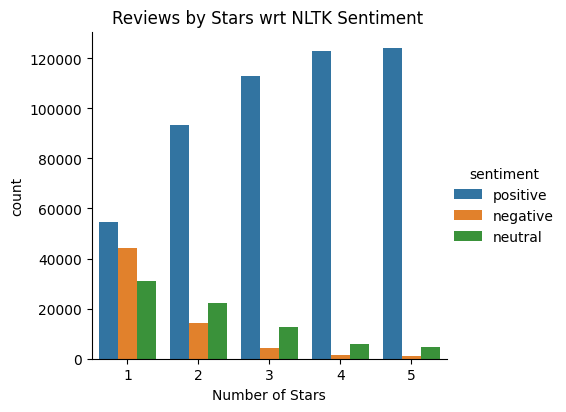

In [20]:
grouped_nltk_sentiment = df_processed.groupby('class_index')['sentiment'].value_counts()
# Plot categorical of sentiment with 
g = sns.catplot(x='class_index',data=df_processed,
                kind="count", hue='sentiment',
                height=4,aspect=1.2)
#handles, labels = g.get_legend_handles_labels()
#g.legend(labels=['Positive', 'Neutral', 'Negative'])
g.set_axis_labels("Number of Stars")
g.fig.suptitle("Reviews by Stars wrt NLTK Sentiment", y=1.02)
plt.show()

In [18]:
'''
# Process sample df
analyzer = SentimentIntensityAnalyzer()
sent_results = list()
start = time.time()
for text in tqdm(sample_df.review_text.to_list()):
    sent_results.append(get_sentiment(text,analyzer))
end = time.time()
print(f"Time elapsed: {round((end - start)/60,1)} min")
#
sample_df['sentiment_raw'] = [val[1] for val in sent_results]
'''

100%|█████████████████████████████████| 100/100 [00:00<00:00, 496.01it/s]

Time elapsed: 0.0 min


In [33]:
'''
# Save dataframe with results as pickled data
file_name = 'dataframe_processed_NLTK.pkl'
#
with open(file_name, 'wb') as f:  # open a text file
    pickle.dump(df_processed, f) # serialize the list
f.close()


# Read back dataframe from pickled
file_name = 'complete_dataframe_processed_NLTKsentiment.pkl'

with open(file_name, 'rb') as f:
    pickle_df = pickle.load(f) # deserialize using load()
'''

"\n# Save dataframe with results as pickled data\nfile_name = 'dataframe_processed_NLTK.pkl'\n#\nwith open(file_name, 'wb') as f:  # open a text file\n    pickle.dump(df_processed, f) # serialize the list\nf.close()\n\n\n# Read back dataframe from pickled\nfile_name = 'complete_dataframe_processed_NLTKsentiment.pkl'\n\nwith open(file_name, 'rb') as f:\n    pickle_df = pickle.load(f) # deserialize using load()\n"

              precision    recall  f1-score   support

          -1       0.90      0.23      0.36    260000
           0       0.17      0.10      0.12    130000
           1       0.49      0.95      0.64    260000

    accuracy                           0.49    650000
   macro avg       0.52      0.42      0.38    650000
weighted avg       0.59      0.49      0.43    650000

Confusion matrix: 
 [[ 58827  53648 147525]
 [  4284  12802 112914]
 [  2527  10435 247038]]


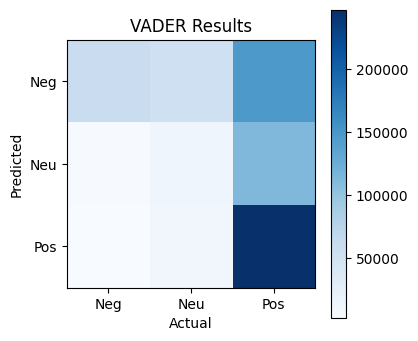

In [73]:
'''
# Convert sentiment to numerical value
def mapfunc(x):
    output = None
    if x=="negative":
        output = -1
    elif x=="neutral":
        output = 0
    elif x=="positive":
        output = 1
    return output

# Apply map function to dataframe column
df_processed['sent_num'] = df_processed['sentiment']\
                                .map(lambda x: mapfunc(x))
df_processed.head()
'''

# Compare actual star sentiment vs. predicted sentiment from VADER
# Print Classification Report
print(classification_report(df_processed['star_sentiment'], df_processed['sent_num']))

# Confusion matrix
mcm_sent = confusion_matrix(df_processed['star_sentiment'], df_processed['sent_num'])
print(f"Confusion matrix: \n", mcm_sent)

# Plot confusion Matrix
plt.figure(figsize = (4,4))
plt.imshow(mcm_sent, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(3)
#plt.xticks(tick_marks, [-1,0,1])
#plt.yticks(tick_marks, [-1,0,1])
plt.xticks(tick_marks, ["Neg","Neu","Pos"])
plt.yticks(tick_marks, ["Neg","Neu","Pos"])
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title('VADER Results')
plt.show()


### Sentiment Analysis with Transformers Library

In [ ]:
start = time.time()

sentiment_pipeline = pipeline(task = "sentiment-analysis",
                            model = "finiteautomata/bertweet-base-sentiment-analysis",
                            numlabels = 3)
trans_sentiment_results = list()

text_list = df_processed.processed_text.sample(n=50).to_list()
for text in text_list:
    trans_sentiment_results.append(sentiment_pipeline(text))

trans_sentiment_results
end = time.time()
print(f"Time elapsed: {round((end - start)/60,1)} min")
#sentiment_results = tqdm(sentiment_pipeline(processed_text))

**Custom Sort DataFrame Function**

In [6]:
def sort_df(mydf):
    # Sort the dataframe
    start = time.time()
    numrows = mydf.shape[0]
    # Sort the dataframe columns by normalized column score
    col_norm = list()
    arranged_columns = list()
    # Intitalize arrays
    sorted_scores = np.zeros((numrows, 1), dtype=np.float32)
    sorted_indices = np.zeros((numrows, 1), dtype=np.int32)
    # Get normalized column score
    col_norm = [np.linalg.norm(mydf[col]) for col in mydf.columns]
    
    # Get the descending sort on the normalized scores
    sorted_scores = np.sort(col_norm)[::-1]
    # Get the indices for a descending sort
    sorted_indices = np.argsort(col_norm)[::-1]
    # Get a list of the sorted column names     
    arranged_columns = df_tfidf.columns[sorted_indices].to_list()
    # Reindex the dataframe
    #sorted_df = mydf.reindex(columns=arranged_columns)
    #sorted_df.iloc[0,:] = sorted_scores
    end = time.time()
    print(f"Time elapsed: {round((end - start)/60,1)} min")
    return sorted_scores, arranged_columns, sorted_indices

'''
# Sort the dataframe
sorted_scores, arranged_columns, sorted_indices = sort_df(df_tfidf)

fig, ax = plt.subplots(figsize=(5, 3))
ax.bar(x=arranged_columns[:10], height=sorted_scores[0:10])
ax.set_xlabel('Counted Words')
ax.set_ylabel('Siginificance')
ax.set_title('TFIDF Top 10 Words')
ax.tick_params(axis='x', labelrotation=45)
plt.show()
'''

"\n# Sort the dataframe\nsorted_scores, arranged_columns, sorted_indices = sort_df(df_tfidf)\n\nfig, ax = plt.subplots(figsize=(5, 3))\nax.bar(x=arranged_columns[:10], height=sorted_scores[0:10])\nax.set_xlabel('Counted Words')\nax.set_ylabel('Siginificance')\nax.set_title('TFIDF Top 10 Words')\nax.tick_params(axis='x', labelrotation=45)\nplt.show()\n\n"

## Model Accuracy Score Comparison

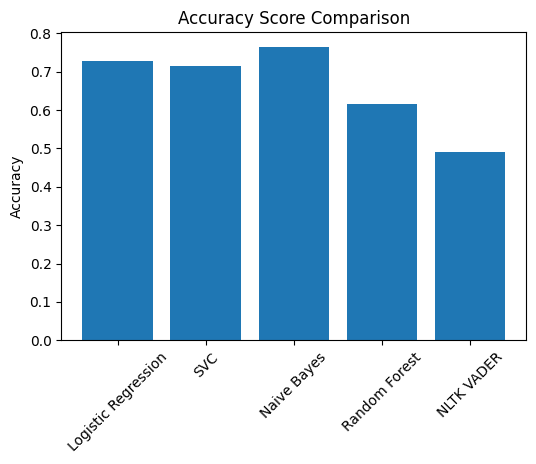

In [71]:

acc_models = ['Logistic Regression', 'SVC', 'Naive Bayes', 'Random Forest', 'NLTK VADER']
acc_scores = [accuracy_score(y_test, log_pred),
                accuracy_score(y_test, nb_y_pred),
                accuracy_score(y_test, svc_y_pred),
                accuracy_score(y_test, rf_y_pred),
                accuracy_score(df_processed['star_sentiment'], df_processed['sent_num'])]
# Plot bar graph
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(x=acc_models, height=acc_scores)
ax.tick_params(axis='x', labelrotation=45)
ax.set_title('Accuracy Score Comparison')
ax.set_ylabel('Accuracy')
plt.show()

## Summary</br>

<span style="color: blue; font-family: Arial; font-size: 16px; background-color: #EEEEEE">
This notebook outlines the operations to perform sentment analysis on the yelp review training dataset comprised of 650k reviews. A preprocessing function was used to transform the reviews lemmatized words with no stop words or special characters. The process took over 20 hours to process the entire 650k reviews. The dataset was written to a local binary file (pickled) to prevent having to regenerate the dataset. </br>

An assumption was made that (1,2) stars are a negative sentiment, a 3 stars equated to a neutral sentiment, and (4,5) stars are a positive sentiment. The processed reviews were then vectorized to create features using TF-IDF. This process yielded a sparse matrix of features to model against the star review ratings. The initial dataset included a equal distribution of number of stars (classes).  

The dataset was split 70% train / 30% test for modeling. Log-regression, SVM, Naive Bayes, and Random Forest multinomial classification models were used to make sentiment prediction. The stars to sentiment conversion, yields an imbalanced set where 'neutral' is 3 stars where 'positive' is both (4,5) stars. Thus a class weighting was supplied to the models to account for the class imbalance.Comparing accuracy results show a Naive Bayes performed the best.

NLTK 'SentimentIntensityAnalyzer' which uses the Valence Aware Dictionary and Sentiment Reasoner (VADER) was used to perform sentiment analysis on the processed reviews. This model is a 'black box' model that operates on the processed reviews. The VADER model applied to the actual text performed the worst on predicting sentinment. 
